In [3]:
%matplotlib inline
import active_subspaces as ac
import numpy as np
import matplotlib.pyplot as plt

## Noise Variance Learning

In [4]:
def ECNOISE(x_b, F, M, N):

    # x_b: a base point in domain; must be a column vector
    # F: function with noise we wish to estimate
    # M: number of points sampled along a curve; must have M>/2
    # N: dimension of domain of f
    
    # Throw an error for not sampling enough points
    if M<2:
        return print('Please select M=2 or larger.')
        
    
    # Initialize storage for difference table
    T = np.zeros((M,M))
    
    # We pick a direction to sample in, and normalize it:
    p = np.ones((N,1))/np.sqrt(N)
    
    # Form difference table
    for i in range(0,M):
        T[i,0] = F(x_b + (i/M)*p)

    for j in range(0,M-1):
        for i in range(0,M-j-1):
            T[i,j+1] = T[i+1,j] - T[i,j]
            
    # Make a row vector to store the k-level estimators (sigma_k^2) 
    S = np.zeros((1,M))
    
    # Build S according to paper; each k-th component of S is the k-th level estimator for the variance in our noise
    # which is computed using a scaled average of the k-th level difference values, from the difference table T
    for i in range(1,M):
        S[0,i] = ((np.math.factorial(i)**2.)/np.math.factorial(2*i))*(1./(M-i))*np.sum(T[:,i]**2,axis=0)

    S=S[:,1:] # Don't need the first column (because first col. of T just holds function values!)
    
    possible_estimator = np.sum(S[:,2:], axis=1)/(M-1)
    est_var = possible_estimator
    
    return [S, est_var[0]]

## Lipschitz Constant Learning

In [5]:
def LIPS(F, M, N, est_var):
    
    # F: noisy function we wish to obtain an estimate of L_! for
    # M: number of times we wish to draw points and estimate L_1
    # N: dimension of inputs
    # est_var: the estimated variance of the noise in f
    
    # We need to estimate max ||f''|| roughly and cheaply
    
    # Constants we need
    std=est_var**0.5
    eps_star=3*std
    
    # Take a random draw
    x_0=10*(2*np.random.rand(N,1) - np.ones((N,1)))

    # Define an arbitrary unit vector
    unit_v=np.ones((N,1))/(N**(1/N))
    
    # Step size
    h=std**0.25

    # Computes a centered finite difference to approximate f'' at x_0
    F_m=F(x_0 - h*unit_v)
    F_0=F(x_0)
    F_p=F(x_0 + h*unit_v)
    diff = abs(F_p - 2*F_0 + F_m)

    # Our guess for ||f''||
    mu_f2=diff/(N*h**2)
    
    # Now we will take draws and estimate L_1
    
    x_vals=np.zeros((N,1)) # matrix to store the vectors we randomly make
    grads=np.zeros((N,1)) # matrix to store the gradients we approximate
    ratios=np.zeros((M,1)) # vector storing the ratios we are intersted in!
    h_star=(8**0.25)*np.sqrt(std/mu_f2) # the prescribed step size by Chen/More

    for j in range(0,M):

        # Take two draws inside a large hypercube and store them
        x=100*(2*np.random.rand(N,1) - np.ones((N,1)))
        y=100*(2*np.random.rand(N,1) - np.ones((N,1)))
        x_vals=np.hstack((x_vals,x))
        x_vals=np.hstack((x_vals,y))

        # For loop to make finite diff approx's 
        # to each partial and form approx gradient at x
        approx_grad_x=np.zeros((N,1))
        for i in range(0,N):
            e = np.zeros((N,1))
            e[i] = 1.0
            approx_grad_x[i] = (F(x + h_star*e) - F(x))/h_star
    
        # Store the gradient at x
        grads=np.hstack((grads,approx_grad_x))
    
        # For loop to make finite diff approx's 
        # to each partial and form approx gradient at y
        approx_grad_y=np.zeros((N,1))
        for p in range(0,N):
            e = np.zeros((N,1))
            e[p] = 1.0
            approx_grad_y[p] = (F(y + h_star*e) - F(y))/h_star
    
        # Store the gradient at y
        grads=np.hstack((grads,approx_grad_y))
    
        # Form ratios to estimate L_1
        # Note we subtract by 2*eps_star, which was mentioned in Callies paper
        diff_1=np.linalg.norm(approx_grad_x - approx_grad_y) - 2*eps_star
        diff_2=np.linalg.norm(x-y)
        r=diff_1/diff_2
        ratios[j]=r
    
    x_vals=x_vals[:,1:]
    grads=grads[:,1:]
    
    # Take most pessimistic draw?
    L_1_est=(np.max(ratios))

    #print('the ratios are', np.transpose(ratios),'and our estimate to L_1 is', L_1_est)
    return [L_1_est]
    
    
    

## STARS

In [6]:
def STARS(x_init,F, mu_star,h):
    
    # x_init: initial x value
    # F: function we wish to minimize
    # mu_star: smoothing parameter
    # h: step length
    
    # Evaluate noisy F(x_init)
    f = F(x_init)
    
    # Draw a random vector of same size as x_init
    u = np.random.normal(0,1,(N,1))
    
    # Form vector y, which is a random walk away from x_init
    y = x_init + (mu_star)*u
    
    # Evaluate noisy F(y)
    g = F(y)
    
    # Form finite-difference "gradient oracle"
    s = ((g - f)/mu_star)*u 
    
    # Take descent step in direction of -s smooth by h to get next iterate, x_1
    x = x_init - (h)*s
   
    # Evaluate noisy F(x_1)
    f=F(x)
    
        
    return [x, f, y, g]

## STARSRV

In [7]:
def STARSRV(x_init,F,u,k,mu_star,h):
    
    # x_init: initial x value
    # F: function we wish to minimize
    # u: Choice of random vector; probably comes from active subspace
    # note that lower f's are evaluations of F(*)
    # k: noise parameter
    # mu_star: smoothing parameter
    # h: step length
    

    
    # Evaluate noisy F(x_init)
    f = F(x_init) + k*(2*np.random.rand(1)-1)
    
    
    # Form vector y, which is a random walk away from x_init
    # in the direction of u, which the user defines
    sclr=np.random.normal(0,1)
    u=sclr*u
    y = x_init + (mu_star)*u
    
    # Evaluate noisy F(y)
    g = F(y) + k*(2*np.random.rand(1) -1)
    
    # Form finite-difference "gradient oracle"
    s = ((g - f)/mu_star)*u 
    
    # Take descent step in direction of -s smooth by h to get next iterate, x_1
    x = x_init - (h)*s
   
    # Evaluate noisy F(x_1)
    f=F(x) + k*(2*np.random.rand(1) -1)
    
        
    return [x, f, y, g]

## Active Subspace Learning

In [8]:
def ACT(x_hist, f_hist):
    
    # x_hist: history of x values - x's are transposed and stored as rows in array x_hist
    # f_hist: history of f values - f's are real-valued an stored as rows in a column vector f_hist
    
    # Compute AS using function values stored in f_hist
    
    # Instantiate a subspace object
    ss = ac.subspaces.Subspaces()

    # Use Local Linears
    df = ac.gradients.local_linear_gradients(x_hist, f_hist) #Estimated gradients using local linear models
    ss.compute(df=df, nboot=0)
    
    # Use Global Quadratic
    # ss.compute(X=x_hist, f=f_hist, nboot=0, sstype='QPHD')
    
    ac.utils.plotters.eigenvalues(ss.eigenvals, ss.e_br)
    ac.utils.plotters.sufficient_summary(x_hist.dot(ss.W1), f_hist)

    return [ss.eigenvecs, ss.eigenvals]

## Example 1. Noisy sphere function.


Let $f: R^N \to R$ equal the sphere function with additive noise; i.e., $$f(x; \xi)=\sum_{i=1}^N x_i^2 + \epsilon (\xi),$$ where $\epsilon \sim U[-k,k]$ is stoachastic additive noise with zero mean and bounded variance $k^2/3$. Then we have $\nabla f(x)=2x$ and one can show that $L_1^*=2$. This means that the value of $||\nabla f(x) -\nabla f(y)||$ will never be larger than twice the value of $2||x-y||$ which is obvious because $||\nabla f(x) -\nabla f(y)||$ literally equals $2||x-y||$.

In [9]:
# Define sphere function with additive noise

# Noise level
k=1e-2

def sphere(x):
    x=x**2
    return (np.sum(x, axis=0) + k*(2*np.random.rand(1) - 1))[0]

N=4 # this is the dimension of the inputs!

x_test=np.sqrt(2)*np.ones(N)

print('Noisy sphere function evaluated at x_test is', sphere(x_test), 'and the error-free value is', 2*N)

Noisy sphere function evaluated at x_test is 7.994993568269253 and the error-free value is 8


### Call ECNoise and estimate noise variance

In [12]:
sphere_noise = ECNOISE(np.ones((N,1)), sphere, 6, N)
est_var=sphere_noise[1]

print(est_var)

2.78943893106013e-06


### Learn L_1

In [13]:
sphere_lips = LIPS(sphere, 6, N, est_var)
L_1_est = sphere_lips[0]

print(L_1_est)

2.0026250664062473


### Perform STARS (full variables)

In [14]:
# STARS optimal hyperparameters

mu_star=((8*est_var*N)/(L_1_est**2*(N+6)**3))**0.25
h=1/(4*L_1_est*(N+4))

print(mu_star,h)

0.012214252258105464 0.015604518551282682


In [15]:
x_init=100*(2*np.random.rand(N,1)-np.ones((N,1)))

print(np.shape(x_init),sphere(x_init))

(4, 1) 16889.36255073336


In [16]:
# Run pure STARs

x=x_init
f=sphere(x)

x_hist=np.array(x)
f_hist=np.array(f)

maxit=200

for i in range(1, maxit):
    s=STARS(x,sphere,mu_star,h)
    x=s[0]
    f=s[1]
    x_hist=np.hstack((x_hist,x))
    f_hist=np.hstack((f_hist,f))
    
print(np.linalg.norm(x),f)

0.44340523953918487 0.20208341322575263


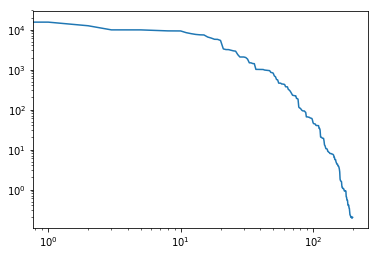

In [17]:
plt.loglog(f_hist)
plt.show()

## Example 2. Noisy "ellipsoid" function

In [18]:
# Define sphere function with additive noise

# Noise level
k=1e-2

N=10 # this is the dimension of the inputs!

# Define a matrix for quadratic form
A=np.eye(N)

for i in range(0,N):
    A[i,i]=2**i

def ellip(x):
    y=A@x
    val=np.transpose(x)@y
    return  (val + k*(2*np.random.rand(1) - 1))[0]

x_test=np.sqrt(2)*np.ones(N)

print('Noisy sphere function evaluated at x_test is', ellip(x_test))

Noisy sphere function evaluated at x_test is 2046.006698362608


### Call ECNoise and estimate noise variance

In [19]:
ellip_noise = ECNOISE(np.ones((N,1)), ellip, 6, N)
est_var=ellip_noise[1]

print(est_var)

1.0923540569000505e-05


### Learn L_1

In [20]:
ellip_lips = LIPS(ellip, 10, N, est_var)
L_1_est = ellip_lips[0]

print(L_1_est)

547.4980745457668


### Perform STARS (full variables)

In [21]:
# STARS optimal hyperparameters

mu_star=((8*est_var*N)/(L_1_est**2*(N+6)**3))**0.25
h=1/(4*L_1_est*(N+4))

print(mu_star,h)

0.0009185061491891382 3.261590074441464e-05


In [22]:
x_init=100*(2*np.random.rand(N,1)-np.ones((N,1)))

print(np.shape(x_init), ellip(x_init))

(10, 1) [141278.26620524]


In [23]:
# Run pure STARs

x=x_init
f=ellip(x)

x_hist=np.array(x)
f_hist=np.array(f)

maxit=10000

for i in range(1, maxit):
    s=STARS(x,ellip,mu_star,h)
    x=s[0]
    f=s[1]
    x_hist=np.hstack((x_hist,x))
    f_hist=np.hstack((f_hist,f))
    
print(np.linalg.norm(x),f)

32.903486455818594 [1234.72381751]


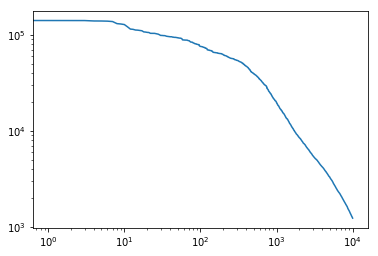

In [24]:
plt.loglog(f_hist)
plt.show()

n should be an integer. Performing conversion.


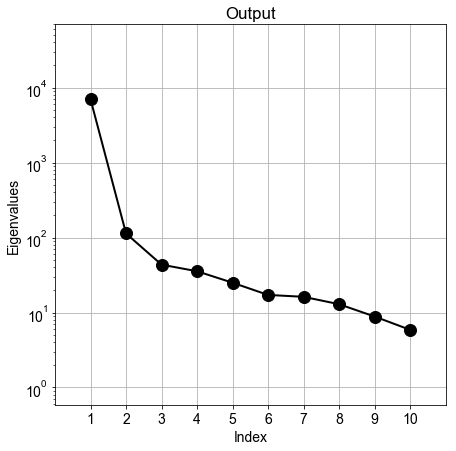

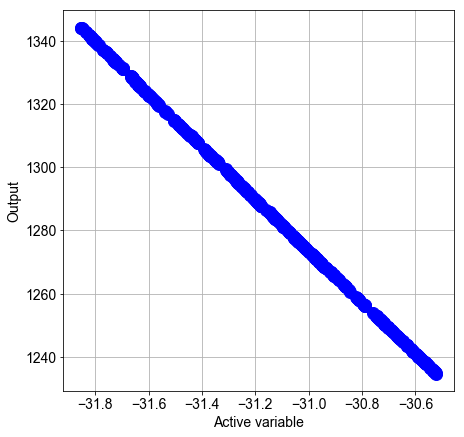

[array([[ 7.54812327e-01,  8.72926282e-02,  9.16195476e-03,
          2.46134997e-01,  2.95789206e-02,  1.36188211e-02,
          7.30620392e-02,  4.56715634e-01,  3.42083451e-01,
          1.73099005e-01],
        [ 5.58641679e-01, -1.58582214e-02, -1.01752649e-01,
         -2.57319793e-01, -3.17462143e-02,  1.28214670e-01,
          8.65674269e-02, -2.79185932e-01, -3.85350061e-01,
         -5.99767219e-01],
        [-3.40793868e-01,  1.30909548e-01, -1.20536891e-01,
          8.85298187e-02,  1.94860434e-02,  1.49493946e-01,
          3.49917250e-01,  5.31230459e-01,  1.80240164e-01,
         -6.20075007e-01],
        [-2.58391601e-02,  1.37913613e-01, -4.13422739e-02,
          3.82317207e-02,  4.30553518e-01,  6.22871674e-01,
         -5.96575532e-01, -5.16173744e-02,  1.83833916e-01,
         -1.06931022e-01],
        [-1.38715528e-02, -6.28689038e-03,  2.06743247e-01,
         -5.45597993e-01, -4.90000244e-01,  5.02551857e-01,
          1.92069571e-02,  3.11824220e-01, -1.015001

In [25]:
ACT(np.transpose(x_hist)[-500:],f_hist[-500:])